# Análisis de Sentimientos en Tweets Usando Modelos de Entrenamiento

## Introducción

En este notebook, exploraremos cómo utilizar modelos de aprendizaje automático para analizar y clasificar sentimientos expresados en tweets. El análisis de sentimientos es una tarea fundamental en el procesamiento del lenguaje natural (NLP) que busca determinar la actitud o emoción expresada en un texto. En este caso, nos centraremos en un conjunto de datos de tweets etiquetados con diferentes emociones.

**Objetivos del Notebook:**

*   Cargar y explorar un dataset de tweets etiquetados con emociones.
*   Preprocesar los datos de texto para prepararlos para el entrenamiento del modelo.
*   Vectorizar los textos utilizando técnicas como TF-IDF.
*   Entrenar y evaluar modelos de clasificación de sentimientos.
*   Analizar los resultados y sacar conclusiones sobre el rendimiento de los modelos.

## Carga de Librerías

```python
# Importar las librerías necesarias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from wordcloud import WordCloud
import string
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import joblib  # o import pickle

# Descargar recursos de NLTK si es necesario
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from wordcloud import WordCloud
import string
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import pickle  # o import pickle

## Cargar el Dataset

In [2]:
# Cargar el dataset
data_expandida = pd.read_csv('emotions.csv') # Asegúrate de que el archivo esté en la misma carpeta o proporciona la ruta correcta

# Visualizar las primeras filas del dataset


# Información general del dataset
print(data_expandida.info())

data_expandida.head()

data = data_expandida.sample(n=40000, random_state=42)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 416809 entries, 0 to 416808
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   text    416809 non-null  object
 1   label   416809 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 6.4+ MB
None


## Análisis Exploratorio de Datos (EDA)

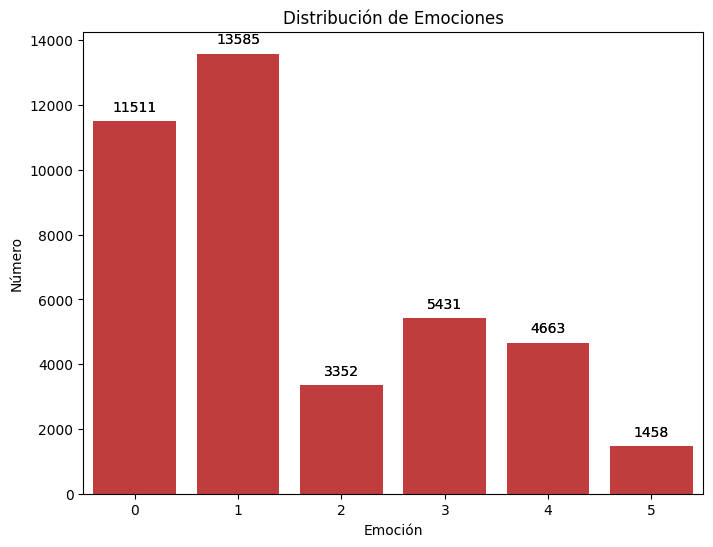

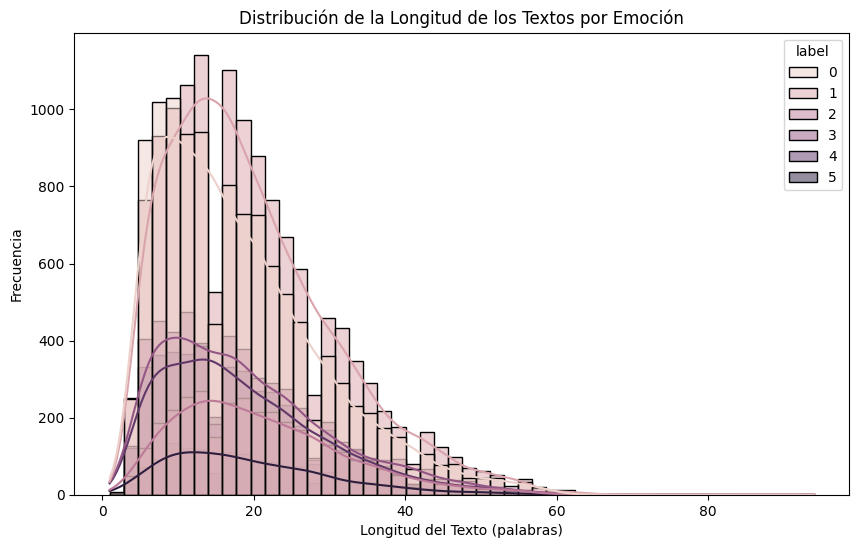

                                                     text  label
400140  i cant explain how i truly feel but some words...      1
75905   i am feeling a bit naughty and not saying who ...      2
204048  i could turn to them but i feel like id be unw...      0
231038   i am feeling a bit listless and melancholy today      0
345003  i changed from frettin to feeling peaceful com...      1
164706  i feel is that the most likeable characters ar...      1
170976  i feel inexplicably uneased when i am with som...      3
203742     i have no complaints but i feel too complacent      1
389421                    i feel so very thrilled for her      1
409097   i don t feel punished at all i feel very aroused      0


In [3]:
# Distribución de las etiquetas
plt.figure(figsize=(8, 6))
sns.countplot(x='label', data=data)
plt.title('Distribución de Emociones')
plt.ylabel('Número')
plt.xlabel('Emoción')

for p in sns.countplot(x='label', data=data).patches:
    sns.countplot(x='label', data=data).annotate(format(p.get_height(), '.0f'), 
                                               (p.get_x() + p.get_width() / 2., p.get_height()), 
                                               ha = 'center', va = 'center', 
                                               xytext = (0, 10), 
                                               textcoords = 'offset points')
plt.show()

# Longitud de los textos (en palabras)
data['longitud_texto'] = data['text'].apply(lambda texto: len(texto.split()))

plt.figure(figsize=(10, 6))
sns.histplot(data=data, x='longitud_texto', hue='label', kde=True, bins=50)
plt.title('Distribución de la Longitud de los Textos por Emoción')
plt.xlabel('Longitud del Texto (palabras)')
plt.ylabel('Frecuencia')
plt.show()

# Ejemplo de algunos textos y sus etiquetas
print(data[['text', 'label']].sample(10))

## Preprocesamiento de Texto

In [4]:
# Definir la función de preprocesamiento
stop_words_english = stopwords.words('english')
lemmatizer = WordNetLemmatizer()

def preprocess_text(text):
    # 1. Minúsculas
    text = text.lower()
    # 2. Eliminar puntuación
    text = ''.join([char for char in text if char not in string.punctuation])
    # 3. Tokenización (dividir en palabras)
    tokens = text.split()
    # 4. Eliminar Stop Words
    tokens = [word for word in tokens if word not in stop_words_english]
    # 5. Lematización (o Stemming)
    tokens = [lemmatizer.lemmatize(word) for word in tokens]
    return ' '.join(tokens)

# Aplica el preprocesamiento a la columna de texto
data['texto_preprocesado'] = data['text'].apply(preprocess_text)

# Visualiza el antes y después del preprocesamiento
print(data[['text', 'texto_preprocesado']].head())

                                                     text  \
36130   id say maybe made them feel foolish but that w...   
138065  i joined the lds church i admit to feeling som...   
146440  i must admit i didnt feel like hugging him not...   
103337  i hate that i can still feel if any nerve is d...   
315528                  im actually feeling a little smug   

                                       texto_preprocesado  
36130   id say maybe made feel foolish would reeeeeeal...  
138065  joined lds church admit feeling somewhat asham...  
146440  must admit didnt feel like hugging angry disgu...  
103337  hate still feel nerve damaged badly enough oft...  
315528                    im actually feeling little smug  


## Vectorización de Texto

In [5]:
# Vectorización TF-IDF
tfidf_vectorizer = TfidfVectorizer(max_features=5000) # Puedes ajustar max_features
X = tfidf_vectorizer.fit_transform(data['texto_preprocesado'])
y = data['label']

print("Forma de la matriz TF-IDF:", X.shape)

# Dividir datos en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y) # stratify=y para mantener proporciones de clase en train/test

Forma de la matriz TF-IDF: (40000, 5000)


## Modelado, Guardar el Modelo y el Vectorizador


Entrenando modelo: Regresión Logística 🚀


c:\Users\cdori\Music\proyecto\hackaton\SIC25-FAVFIX\env\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


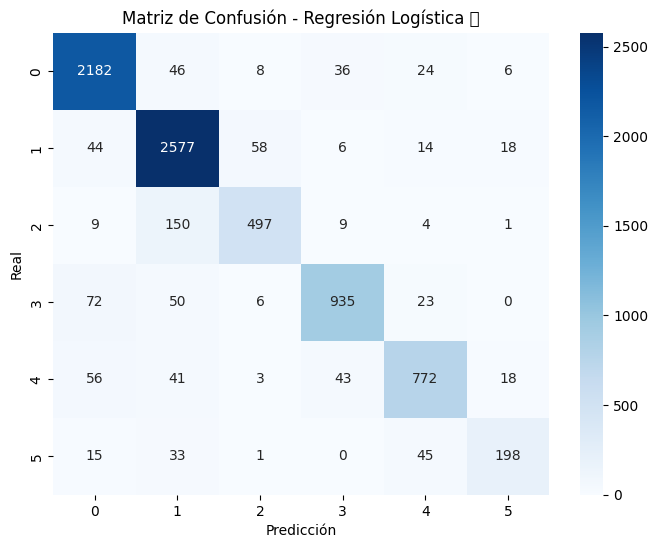


Entrenando modelo: Naive Bayes 🚀


c:\Users\cdori\Music\proyecto\hackaton\SIC25-FAVFIX\env\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


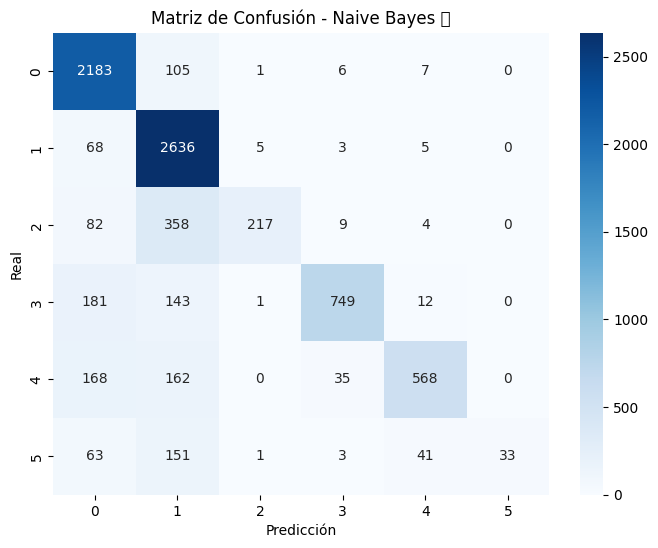


Entrenando modelo: XGBoost 🌳 🚀


c:\Users\cdori\Music\proyecto\hackaton\SIC25-FAVFIX\env\Lib\site-packages\xgboost\core.py:158: UserWarning: [06:09:11] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\cdori\Music\proyecto\hackaton\SIC25-FAVFIX\env\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 127795 (\N{DECIDUOUS TREE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\cdori\Music\proyecto\hackaton\SIC25-FAVFIX\env\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


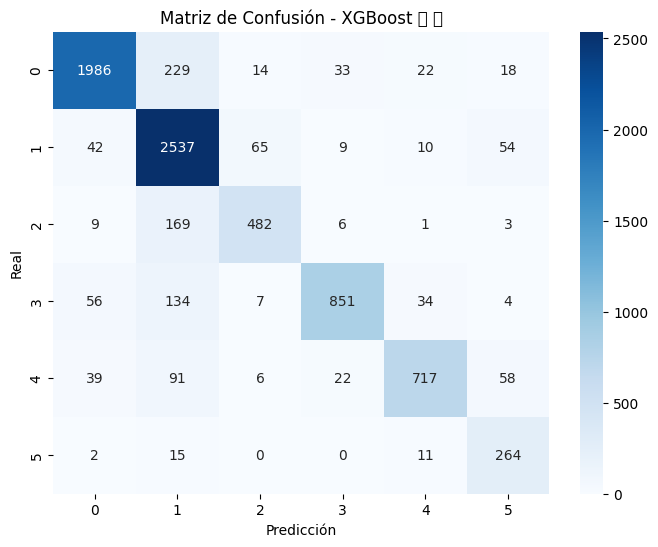


Entrenando modelo: Random Forest 🌲 🚀


c:\Users\cdori\Music\proyecto\hackaton\SIC25-FAVFIX\env\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\cdori\Music\proyecto\hackaton\SIC25-FAVFIX\env\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\cdori\Music\proyecto\hackaton\SIC25-FAVFIX\env\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average,

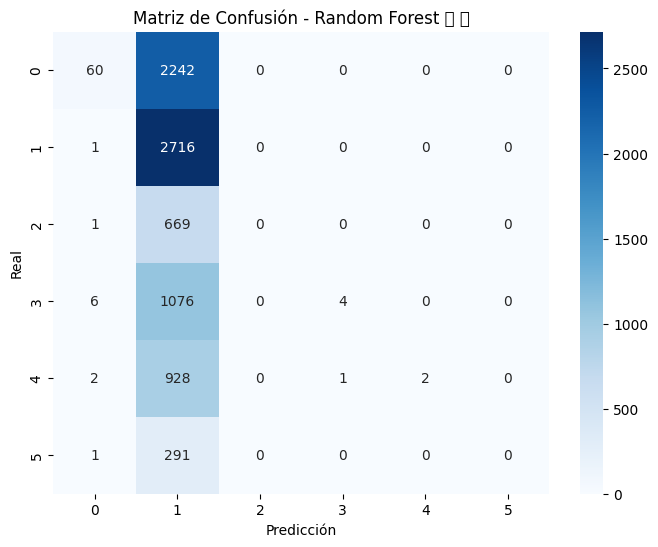

In [6]:
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import xgboost as xgb
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder

# Codificar las etiquetas de clase
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

# Definición de modelos 🤖
modelos = {
    'Regresión Logística': LogisticRegression(max_iter=1000),  # Aumenta max_iter si es necesario
    'Naive Bayes': MultinomialNB(),
    'XGBoost 🌳': xgb.XGBClassifier(
        max_depth=6,
        learning_rate=0.1,
        n_estimators=100,
        use_label_encoder=False,
        eval_metric='logloss'
    ),
    'Random Forest 🌲': RandomForestClassifier(
        n_estimators=200,
        max_depth=10,
        min_samples_split=5,
        min_samples_leaf=2,
        random_state=42,
        n_jobs=-1
    )
}

# Entrenamiento y evaluación 📈
resultados = {}
for nombre_modelo, modelo in modelos.items():
    print(f"\nEntrenando modelo: {nombre_modelo} 🚀")
    modelo.fit(X_train, y_train_encoded)
    y_pred = modelo.predict(X_test)
    
    # Métricas
    accuracy = accuracy_score(y_test_encoded, y_pred)
    reporte = classification_report(y_test_encoded, y_pred)
    matriz_confusion = confusion_matrix(y_test_encoded, y_pred)
    
    resultados[nombre_modelo] = {
        'accuracy': accuracy,
        'reporte': reporte,
        'matriz_confusion': matriz_confusion,
        'modelo': modelo
    }
    
    # Visualización de matriz de confusión
    plt.figure(figsize=(8, 6))
    sns.heatmap(matriz_confusion, annot=True, fmt='d', cmap='Blues')
    plt.title(f'Matriz de Confusión - {nombre_modelo} 📊')
    plt.xlabel('Predicción')
    plt.ylabel('Real')
    plt.show()

# Guardar los modelos entrenados con pickle
for nombre_modelo, res in resultados.items():
    with open(f'modelo_sentimientos_{nombre_modelo.lower().replace(" ", "_").replace("🌳", "xgboost").replace("🌲", "random_forest")}.pkl', 'wb') as f:
        pickle.dump(res['modelo'], f)

# Guardar el vectorizador TF-IDF con pickle
with open('tfidf_vectorizador_sentimientos.pkl', 'wb') as f:
    pickle.dump(tfidf_vectorizer, f)

## Evaluación del Modelo y Conclusiones

En esta sección, analizaremos los resultados de los modelos y sacaremos conclusiones. Observaremos el accuracy, el reporte de clasificación (que incluye precisión, recall, F1-score) y la matriz de confusión para entender el rendimiento de cada modelo en detalle.

**Puntos a Considerar en la Evaluación:**

*   **Accuracy:**  ¿Qué tan bien clasifica el modelo en general?
*   **Precisión (Precision):**  De todas las predicciones positivas, ¿cuántas fueron realmente correctas?  Importante para minimizar falsos positivos.
*   **Recall (Exhaustividad):** De todos los casos positivos reales, ¿cuántos identificó correctamente el modelo? Importante para minimizar falsos negativos.
*   **F1-score:**  Promedio armónico de precisión y recall.  Útil cuando hay un desbalance entre precisión y recall.
*   **Matriz de Confusión:**  Muestra el número de verdaderos positivos, verdaderos negativos, falsos positivos y falsos negativos, dando una visión más detallada de los errores del modelo.

**Conclusiones Iniciales:**

*   ¿Qué modelo funcionó mejor en términos de accuracy y otras métricas relevantes?
*   ¿Dónde falla el modelo? (Mirar el reporte de clasificación).
*   ¿Qué podemos mejorar en futuras iteraciones? (Preprocesamiento, vectorización, modelos, más datos, etc.)

## Próximos Pasos y Posibles Expansiones

Este notebook es un punto de partida. Aquí hay algunas ideas para expandirlo y mejorarlo:

*   **Mejorar el Preprocesamiento:**
    *   Probar diferentes técnicas de lematización/stemming o usar spaCy para un preprocesamiento más avanzado.
    *   Manejar emojis, hashtags, menciones (si son relevantes en tu dataset).
    *   Corregir errores ortográficos (si es posible y relevante).
*   **Experimentar con Diferentes Vectorizaciones:**
    *   Probar `CountVectorizer` (Bag of Words).
    *   Usar n-gramas (e.g., bi-gramas, tri-gramas) en la vectorización para capturar frases.
    *   Considerar Word Embeddings (Word2Vec, GloVe, FastText) para representar las palabras de forma más semántica (esto sería un paso más avanzado).
*   **Probar Más Modelos:**
    *   Random Forest, Gradient Boosting Machines (como XGBoost, LightGBM).
    *   Redes Neuronales (para un enfoque más profundo, pero requiere más datos y ajuste).
*   **Ajuste de Hiperparámetros:**
    *   Usar técnicas como Grid Search o Random Search para encontrar los mejores parámetros para los modelos.
*   **Feature Engineering Adicional:**
    *   Extraer características adicionales del texto, como análisis de sentimiento, uso de ciertas palabras clave, etc.
*   **Recopilación de Más Datos:** Si el rendimiento no es suficiente, más datos etiquetados suelen ayudar.
*   **Manejo de Desbalance de Clases:** Si las clases están muy desbalanceadas, usar técnicas de sobremuestreo (oversampling) o submuestreo (undersampling).
*   **Validación Cruzada:** Usar validación cruzada para una evaluación más robusta del rendimiento del modelo.
